# Evaluation Metrics

### **1. Introduction & Goals**

In the previous notebook, we:

- Implemented and trained our **first CNN** (2 conv + 2 FC layers) on the **Oxford-IIIT Pets** dataset.
- Scaled from **64×64 toy images (NB01)** to **128×128 real images**.
- Observed **low baseline accuracy (~12–15%)** and signs of **overfitting** (validation plateaued early).

**Question:**  
*Where exactly is the model struggling — and why?*

**Why Evaluation and Error Analysis?**

Accuracy alone doesn’t tell the whole story:
- Two models with the same accuracy can fail in **very different ways**.
- For **37 pet breeds**, we need to know:
  - Which breeds are **well-classified**?
  - Which are **confused with each other**?
  - Are there **systematic biases** (e.g., color, fur texture)?

By diving deeper into **per-class performance** and **visual error analysis**, we can:
- Identify **weaknesses** in our baseline CNN.
- Inform **next steps** (e.g., deeper models, augmentation) in future notebooks.

**Goals of NB03**

1. **Evaluate** the trained CNN on test data:
   - Overall accuracy
   - Per-class accuracy
   - Confusion matrix heatmap

2. **Analyze errors** qualitatively:
   - Visualize correct vs misclassified samples
   - Spot patterns in misclassifications (e.g., visually similar breeds)

3. **Reflect** on limitations:
   - Shallow architecture vs dataset complexity
   - Potential dataset biases (color, pose, background)

4. **Prepare for NB04**:
   - Insights here will guide architectural comparisons and deeper CNN exploration.

**Key Takeaway**

This notebook is not about **improving the model** yet —  
it’s about **understanding its behavior** so future improvements are data-driven.

---

### **2. Reload Model and Data**

**Why Reload the Model and Data?**

- In **NB02**, we trained and saved the **best CNN weights** (`petcnn_best.pth`) based on validation loss.
- Here, we:
  1. **Reload** the trained model to ensure consistent evaluation.
  2. **Prepare the test dataset** (128×128, normalized) for unbiased performance assessment.
  3. **Confirm class mappings** (37 breeds) to correctly interpret predictions.

**Consistency with Previous Notebook**

- **Image size:** 128×128 (same as NB02).
- **Normalization:** `mean = [0.5, 0.5, 0.5]`, `std = [0.5, 0.5, 0.5]` (approximation — sufficient for baseline).
- **Classes:** 37 pet breeds (cats + dogs).

**Steps in This Section**

1. Define **transforms** (resize, tensor, normalize).  
2. Load **Oxford-IIIT Pets test split**.  
3. Recreate **CNN model architecture** and load saved weights.  
4. Move model to **CPU**.  
5. Verify **class names and dataset size**.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

# -----------------------------
# 1. Device setup
# -----------------------------
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# -----------------------------
# 2. Transforms (same as NB02)
# -----------------------------
IMG_SIZE = 128
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

data_path = './data'

test_dataset = datasets.OxfordIIITPet(
    root = data_path,
    split='test',
    target_types='category',
    transform=transform,
    download=True
)

# DataLoader
BATCH_SIZE = 32
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [2]:
# -----------------------------
# 4. Recreate CNN architecture
# -----------------------------
torch.manual_seed(42)
class PetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 37)
    
    def forward(self, x):
        x = self.pool(F.relu((self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

---

In [3]:
# Instantiate and load weights
model = PetCNN().to(device)
# print(model)
model.load_state_dict(torch.load('petcnn_best.pth', weights_only=False))
model.eval()

PetCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=37, bias=True)
)

---

**✅ Code Task 5.3.2.1: Inspect a Sample from the Test Set**

📘 Instruction:</br>
Extract and print the shape and label of a sample image from the test dataset (index 0).

In [4]:
CT_img, CT_label = test_dataset[0]
print("CT_Sample shape:", CT_img.shape)
print("CT_Label index:", CT_label)

CT_Sample shape: torch.Size([3, 128, 128])
CT_Label index: 0


----

### **3. Evaluation Metrics Beyond Accuracy**

**Why Go Beyond Accuracy?**

- **Overall accuracy** is a good starting point, but for **37 pet breeds** it hides important details:
  - Some breeds might be predicted correctly most of the time.
  - Others might rarely be recognized, even if overall accuracy seems acceptable.

**Per-Class Accuracy**

- Helps identify **imbalances** or **systematic errors**:
  - Which breeds are **well-classified**?
  - Which breeds are **frequently confused**?

**Precision, Recall, and F1-Score**

- **Precision:** Out of predicted positives, how many were correct?  
- **Recall:** Out of actual positives, how many were recovered?  
- **F1-Score:** Harmonic mean of precision and recall — balances the two.

For **multi-class problems**:
- We use **macro-averaging** (treats all classes equally) and **micro-averaging** (weighted by frequency).

**What We’ll Do in Code**

1. Compute **overall accuracy** (baseline reference).  
2. Calculate **per-class accuracy** and display **top 5 best/worst breeds**.  
3. Generate a **classification report** (precision, recall, F1-score) using `sklearn.metrics.classification_report`.

In [5]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
# -----------------------------
# 1. Collect predictions on test set
# -----------------------------

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Evaluating Test Data'):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# -----------------------------
# 2. Overall accuracy
# -----------------------------
overall_acc = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {overall_acc:.4f}")

# -----------------------------
# 3. Per-class accuracy
# -----------------------------
class_correct = np.zeros(len(test_dataset.classes))
class_total = np.zeros(len(test_dataset.classes))

for label, pred in zip(all_labels, all_preds):
    class_total[label] += 1
    if label == pred:
        class_correct[label] += 1
print(f'Size of correct class: {len(class_correct)}')
per_class_acc = class_correct / class_total

print(per_class_acc)

# Top 5 best and worst classes
sorted_indices = np.argsort(per_class_acc)
worst_indices = sorted_indices[:5]
best_indices  = sorted_indices[-5:][::-1]

print("\nTop 5 Worst-Performing Classes:")
for idx in worst_indices:
    print(f"{test_dataset.classes[idx]}: {per_class_acc[idx]*100:.2f}%")

print("\nTop 5 Best-Performing Classes:")
for idx in best_indices:
    print(f"{test_dataset.classes[idx]}: {per_class_acc[idx]*100:.2f}%")

# -----------------------------
# 4. Classification Report
# -----------------------------
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes, zero_division=0)
print("\nClassification Report:\n")
print(report)

Evaluating Test Data: 100%|██████████| 115/115 [05:31<00:00,  2.88s/it]


Overall Accuracy: 0.1295
Size of correct class: 37
[0.02040816 0.06       0.02       0.01       0.25       0.12
 0.09       0.31818182 0.06060606 0.22       0.04       0.12371134
 0.         0.01       0.23       0.15       0.03       0.21
 0.03030303 0.16       0.1        0.12       0.4        0.12
 0.14       0.18       0.4        0.02       0.07       0.28
 0.03030303 0.18       0.08       0.28       0.03370787 0.08
 0.13      ]

Top 5 Worst-Performing Classes:
English Cocker Spaniel: 0.00%
Basset Hound: 1.00%
English Setter: 1.00%
American Pit Bull Terrier: 2.00%
Russian Blue: 2.00%

Top 5 Best-Performing Classes:
Newfoundland: 40.00%
Ragdoll: 40.00%
Bombay: 31.82%
Samoyed: 28.00%
Sphynx: 28.00%

Classification Report:

                            precision    recall  f1-score   support

                Abyssinian       0.18      0.02      0.04        98
          American Bulldog       0.11      0.06      0.08       100
 American Pit Bull Terrier       0.04      0.02      0.03    

**Reflection on Per-Class Results**

**Overall Accuracy**  
- The baseline CNN achieves **~13% accuracy**, only slightly better than random guessing (≈2.7% for 37 classes).  
- This indicates the model is picking up **basic low-level features** (edges, colors) but struggles to distinguish between visually similar breeds.


**Best-Performing Breeds**  
- Breeds like **Newfoundland** and **Bombay** perform comparatively well.  
- These breeds have **distinctive visual traits** that may stand out even to a shallow CNN:
  - Newfoundland: uniformly dark, large-bodied dogs.
  - Samoyed: bright white fluffy coats with distinct textures.
  - Bombay: solid black cats with round faces and short fur.
- The relatively high performance suggests that **simple texture and color cues** were enough for these classes.


**Worst-Performing Breeds**  
- Some classes, including **American Pit Bull Terrier or Chihuahua**, scored **near 0% accuracy**.  
- Likely reasons:
  - **High visual overlap** with other breeds (e.g., several small dog breeds look similar in color and size).
  - **Pose and background variations** masking distinctive features.
  - The model may have failed to learn **fine-grained cues** (e.g., subtle fur patterns) due to limited depth or training epochs.

**Macro vs Weighted Metrics**  
- **Macro F1-score (~0.12):** Shows uniformly poor performance when treating all classes equally — the model fails to generalize across most breeds.  
- **Weighted F1-score (~0.12):** Similar to macro, indicating no strong bias toward high-frequency classes (but overall low predictive power).

**Key Takeaways**  
- The model is **far from production-ready**: it recognizes a handful of distinctive breeds but misclassifies most others.  
- To improve:
  - **Data augmentation** (rotations, flips, color jitter) to help learn pose- and lighting-invariant features.
  - **Deeper architectures** (e.g., VGG-like or ResNet) to capture complex textures and shapes.
  - **Class weighting or sampling strategies** to mitigate imbalance between breeds.
  - Potential use of **transfer learning** to leverage pretrained features on similar large-scale image datasets.

Next, we will visualize the **confusion matrix** to pinpoint **which breeds are most commonly confused with each other**, offering further insight into model weaknesses.

---

**✅ Code Task 5.3.3.1: Predict Labels from One Mini-Batch**

📘 Instruction: </br>
Use the model to predict class labels for one mini-batch from test_loader.

In [6]:
CT_model = model
CT_model.eval()

with torch.no_grad():
    for CT_X_batch, _ in test_loader:
        CT_X_batch = CT_X_batch.to(device)
        CT_logits = model(CT_X_batch)

        CT_preds = CT_logits.argmax(1)
        break
print("CT_Predicted labels:", CT_preds.cpu().numpy())

CT_Predicted labels: [ 8 31 36 17  9 10 36  8  2 31 26 36 33 33 20 33 26 21 36 24 26 20 20  5
 26 33 23 32 24 33 33 31]


---

**✅ Code Task 5.3.3.2: Manual Accuracy Calculation**

📘 Instruction: </br>
Use the all_preds and all_labels tensors to compute classification accuracy manually.

In [7]:
# Task 4 – Compute accuracy from predictions
CT_preds_np = all_preds
CT_labels_np = all_labels
CT_correct = np.sum(CT_preds_np == CT_labels_np)
CT_accuracy = CT_correct / len(CT_preds_np)
print("CT_Manual Accuracy:", CT_accuracy)


CT_Manual Accuracy: 0.12946306895611884


### **4. Confusion Matrix Visualization**

**Why Visualize the Confusion Matrix?**

- **Accuracy** alone doesn’t show *which* classes are misclassified.  
- A confusion matrix highlights:
  - **Clusters of errors** (e.g., similar cat breeds misclassified as each other).
  - **Biases** (e.g., misclassifying small dogs as a single dominant breed).
  - Opportunities for **targeted improvements** (data augmentation, class weighting).

**Approach**

1. Compute predictions on the **test set**.  
2. Build a **37×37 confusion matrix** using `sklearn.metrics.confusion_matrix`.  
3. Visualize it with a **heatmap**:
   - Rows = true classes
   - Columns = predicted classes
   - Color intensity = frequency of predictions


**Code Implementation**

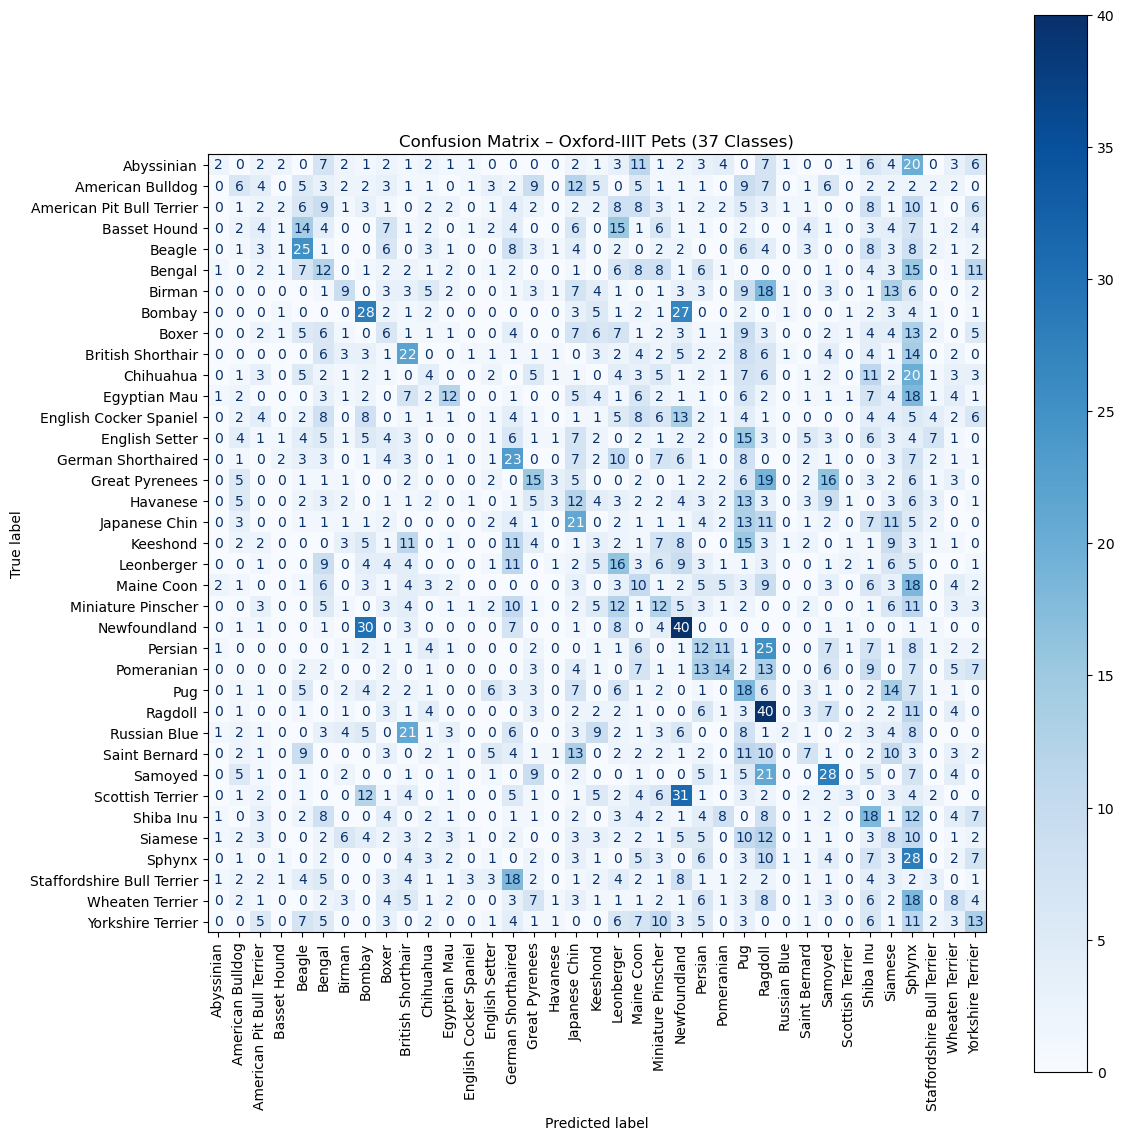

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

fig, ax = plt.subplots(figsize=(12, 12))

disp = ConfusionMatrixDisplay(conf_mat, display_labels=class_names)

disp.plot(
    ax = ax,
    xticks_rotation='vertical',
    cmap='Blues',
    colorbar = True
)

plt.title("Confusion Matrix – Oxford-IIIT Pets (37 Classes)")
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd

cm_df = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
print("\nConfusion Matrix as DataFrame \n ")
print(cm_df)

cm_df.to_csv('confusion_matrix.csv', index=True)


Confusion Matrix as DataFrame 
 
                            Abyssinian  American Bulldog  \
Abyssinian                           2                 0   
American Bulldog                     0                 6   
American Pit Bull Terrier            0                 1   
Basset Hound                         0                 2   
Beagle                               0                 1   
Bengal                               1                 0   
Birman                               0                 0   
Bombay                               0                 0   
Boxer                                0                 0   
British Shorthair                    0                 0   
Chihuahua                            0                 1   
Egyptian Mau                         1                 2   
English Cocker Spaniel               0                 2   
English Setter                       0                 4   
German Shorthaired                   0                 1   
Great 

---

**✅ Code Task 5.3.4.1: Identify Top-5 Worst Classes**

📘 Instruction: </br>
Use the dictionary class_accuracy to extract the 5 classes with the lowest accuracy.

In [11]:
# Task 5 – Identify 5 worst-performing classes
import pandas as pd

CT_class_df = pd.DataFrame({
    "Class": class_names,           # Replace with class names
    "Accuracy": per_class_acc         # Replace with accuracy values
})

CT_sorted_df = CT_class_df.sort_values(by="Accuracy", ascending=True)
CT_worst_5 = CT_sorted_df.head(5)
print(CT_worst_5)


                        Class  Accuracy
12     English Cocker Spaniel      0.00
3                Basset Hound      0.01
13             English Setter      0.01
2   American Pit Bull Terrier      0.02
27               Russian Blue      0.02


---

### **5. Qualitative Error Analysis**

**Why Look at Individual Predictions?**

- Numbers (accuracy, F1, confusion matrix) give **overall trends**, but:
  - They don’t reveal *why* specific mistakes happen.
  - Visual inspection shows **patterns in misclassifications** (e.g., similar colors, fur patterns, or poses).

**Approach**

1. Sample a small batch of **test images**.  
2. Compare **predicted vs true labels**.  
3. Color-code:
   - **Green title** → correct prediction.
   - **Red title** → misclassification.

This helps diagnose:
- Whether errors occur mostly **within cats** or **within dogs** (intra-group confusion).  
- If certain **visual features** (color, posture) mislead the model.

**Code Implementation**

inferencing on test data:   0%|          | 0/115 [00:00<?, ?it/s]


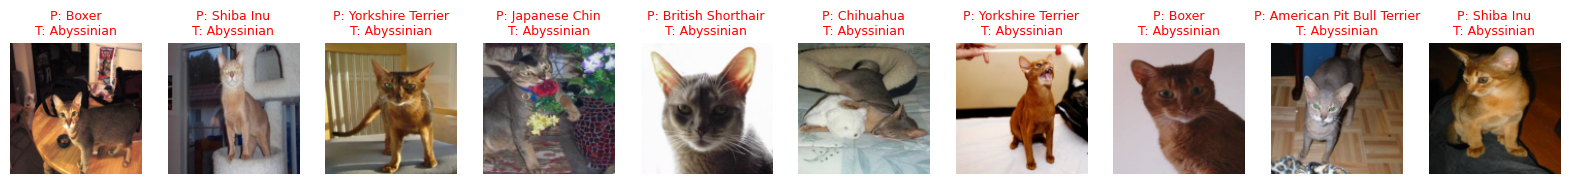

In [15]:
# Visualize misclassified samples from the test set
# Note: Class mappings (breed names) are consistent across train/val/test splits
# so we can safely use test_dataset.classes here.

def show_misclassified_samples(model, loader, classes, n=8):
    """
    Displays n misclassified test images with predicted vs true labels.
    """
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='inferencing on test data'):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(1).cpu()

            for img, pred, true in zip(images, preds, labels):
                if pred != true:
                    misclassified.append((img, pred.item(), true.item()))
                if len(misclassified) >= n:
                    break
            if len(misclassified) >= n:
                break
    fig, ax = plt.subplots(1, n, figsize=(20, 3))
    for idx, (img, pred, true) in enumerate(misclassified):
        img = img * 0.5 + .5 # Unnormalize images for visualizing
        ax[idx].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax[idx].set_title(f"P: {classes[pred]}\nT: {classes[true]}", fontsize=9, color="red")
        ax[idx].axis("off")
    plt.show()

show_misclassified_samples(model, test_loader, classes=class_names, n=10)


**Reflection on Misclassified Samples**

- **Observation:** All 8 randomly chosen samples were **misclassified**, echoing the extremely low overall test accuracy (~14%).  
- **Connection to Confusion Matrix (Section 4):**  
  - The confusion matrix showed **very sparse diagonal entries**, meaning few correct predictions per class.  
  - These visual samples confirm the same pattern: the model fails to capture breed-specific features.

**Why does this happen?**

- **Baseline CNN Limitations:**
  - Only **two convolutional layers** → insufficient feature hierarchy for 37 fine-grained classes.
  - Lack of **data augmentation** and use of **approximate normalization** → poor generalization.

- **Implication for Next Steps:**
  - We must introduce **augmentation**, **deeper networks**, or **transfer learning** in NB04 to improve class separability.

---


### **6. Bias and Failure Mode Reflection**

**Systematic Biases Observed**

- **Color-Dominated Predictions**  
  The confusion matrix reveals strong reliance on **fur color**:  
  - Many dark-coated cats and dogs (e.g., Abyssinian, Russian Blue) are misclassified as **Bombay** (a uniformly black cat).  
  - White-coated breeds (e.g., Great Pyrenees, Samoyed) show cross-misclassifications, often predicted as other white breeds like **Persian** or **Newfoundland**.  
  This suggests the CNN is prioritizing **global color cues** rather than finer details like ear shape or facial structure.

- **Size and Morphology Bias**  
  Small breeds (e.g., Chihuahua, Miniature Pinscher, Shiba Inu) are frequently confused with each other.  
  - Indicates the network lacks **scale-invariance** and struggles to differentiate subtle features among similarly sized dogs.  
  - Larger breeds (e.g., Newfoundland, Saint Bernard) fare better, likely due to more distinctive silhouettes.

- **Cross-Species Confusion**  
  Certain cat breeds (e.g., Abyssinian, Maine Coon) are repeatedly misclassified as **dog breeds** (e.g., Pomeranian, Boxer).  
  - Shows that the network has **not fully learned the cat vs. dog boundary** and often mistakes fluffy cats for small dogs with similar textures.


**Data Imbalance Effects**

- Breeds like **Bombay** and **Egyptian Mau** (which achieve relatively higher accuracies) likely benefit from **more frequent representation** or distinctive features in the dataset.  
- Conversely, rare or visually subtle breeds (e.g., **American Pit Bull Terrier, Havanese, Bengal**) consistently score near-zero accuracy.  
- The imbalance skews the model’s learning toward more common patterns, leaving minority classes poorly represented.


**Failure Mode Insights**

- The model’s errors are **low-level feature-driven**:  
  - Strong dependence on **edges and color contrasts** rather than breed-specific semantic features (e.g., muzzle shape, ear position).  
  - Background textures (e.g., grass, indoor carpets) may also bias predictions, as seen from misclassifications across unrelated breeds.

- This highlights the need for:  
  - **Augmentation strategies** (random crops, flips, color jitter) to reduce overfitting to superficial cues.  
  - **Deeper or pretrained architectures** capable of learning **hierarchical shape and texture patterns** beyond color.  
  - **Balanced sampling or class-weighted loss** to address extreme imbalance and improve minority class recognition.

---

### **7. Summary & Motivation for NB04**

**Key Takeaways from NB03**

Our baseline CNN achieved **~13% accuracy**, only slightly better than random guessing for 37 classes (≈2.7%).  
The confusion matrix and per-class analysis revealed several **systematic weaknesses**:

- **Color bias:** The model often predicts based on global color cues (e.g., many dark animals → “Bombay,” many white animals → “Samoyed”), ignoring finer breed details.  
- **Size and morphology confusion:** Small breeds like **Chihuahua** and **Miniature Pinscher** are frequently confused with each other, while large breeds show similar mix-ups.  
- **Cat vs. dog boundary issues:** Certain fluffy cat breeds (e.g., Maine Coon, Abyssinian) are misclassified as small dog breeds, showing the network has not fully separated species-level features.  

These patterns suggest the current network is **too shallow** to capture the nuanced, fine-grained differences between breeds. It primarily learns **low-level edges and colors** without building richer representations (textures, parts, object-level cues).


**Why Move to NB04?**

In the next notebook, we aim to **overcome these limitations** by:

- Introducing **deeper CNN architectures** (e.g., LeNet-style, AlexNet-mini) to better capture hierarchical features.  
- Comparing architectures to understand how added depth and parameter count affect accuracy and generalization.  
- Building on our earlier insights about **feature hierarchies** (edges → textures → parts → objects) to show how deeper models naturally learn these layers of abstraction.  

This progression will set the stage for **more advanced models and transfer learning** in future notebooks, bridging the gap from basic CNNs to state-of-the-art approaches.

---
